<center><h1>Marketing Campaign Data with Conversion Prediction</h1></center>

In this notebook we will be diving into an anonymous organization's social media ad campagin. The data was accessed from a public Kaggle resource which can be accessed <a href='https://www.kaggle.com/datasets/loveall/clicks-conversion-tracking?resource=download'>here</a>. 

The file `KAG_conversion_data.csv` contains 1143 observations in 11 variables. Below is a description of each column in the dataset:

`ad_id`: an unique ID for each ad.

`xyz_campaign_id`: an ID associated with each ad campaign of XYZ company.

`fb_campaign_id`: an ID associated with how Facebook tracks each campaign.

`age`: age of the person to whom the ad is shown.

`gender`: gender of the person to whim the add is shown

`interest`: a code specifying the category to which the person’s interest belongs (interests are as mentioned in the person’s Facebook public profile).

`Impressions`: the number of times the ad was shown.

`Clicks`: number of clicks on for that ad.

`Spent`: Amount paid by company xyz to Facebook, to show that ad.

`Total conversion`: Total number of people who enquired about the product after seeing the ad.

`Approved conversion`: Total number of people who bought the product after seeing the ad.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

df = pd.read_csv('KAG_conversion_data.csv')

df.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


In [2]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   xyz_campaign_id      1143 non-null   int64  
 2   fb_campaign_id       1143 non-null   int64  
 3   age                  1143 non-null   object 
 4   gender               1143 non-null   object 
 5   interest             1143 non-null   int64  
 6   Impressions          1143 non-null   int64  
 7   Clicks               1143 non-null   int64  
 8   Spent                1143 non-null   float64
 9   Total_Conversion     1143 non-null   int64  
 10  Approved_Conversion  1143 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB


,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
count,1.143000e+03,1143.000000,1143.000000,1143.000000,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000
mean,9.872611e+05,1067.382327,133783.989501,32.766404,1.867321e+05,33.390201,51.360656,2.855643,0.944007
std,1.939928e+05,121.629393,20500.308622,26.952131,3.127622e+05,56.892438,86.908418,4.483593,1.737708
min,7.087460e+05,916.000000,103916.000000,2.000000,8.700000e+01,0.000000,0.000000,0.000000,0.000000
25%,7.776325e+05,936.000000,115716.000000,16.000000,6.503500e+03,1.000000,1.480000,1.000000,0.000000
50%,1.121185e+06,1178.000000,144549.000000,25.000000,5.150900e+04,8.000000,12.370000,1.000000,1.000000
75%,1.121804e+06,1178.000000,144657.500000,31.000000,2.217690e+05,37.500000,60.025000,3.000000,1.000000
max,1.314415e+06,1178.000000,179982.000000,114.000000,3.052003e+06,421.000000,639.949998,60.000000,21.000000


It seems that there are no null values in the dataset and there are no obvious outliers in the features by looking at the quantile ranges. However, upon further inspection, some of the data is erroneous since there were no `Clicks` yet a non-zero `Total Conversion`. There cannot be a conversion if a user did not click on the ad.

In [3]:
print(f"Number of Conversion with no Clicks: {len(df.loc[((df['Clicks'] == 0) & (df['Total_Conversion'] !=0)), ])}")

Number of Conversion with no Clicks: 204


We can impute the click values based on their nearest neighbours using a KNN imputer. 

In [4]:
from sklearn.impute import KNNImputer

# Make all 0 clicks NaN values to impute
df['Clicks'].replace(0, np.nan, inplace=True)

imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(imputer.fit_transform(df.drop(columns=["gender", "age"])))

df["Clicks"] = df_imputed[5]

We have now imputed the `Clicks` column with the closest data points where the other columns are similar. 

The columns `ad_id`, `xyz_campaign_id` and `fb_campaign_id` are all identifying tags for the marketing campaigns. This information is redundant and therefore we will only keep `xyz_campaign_id`. Additionally, the `interest` column provides very little information to a users behaviour and whether they will perform a conversion or not, therefore we will drop this column as well.

In [5]:
df = df.drop(columns=['ad_id', 'fb_campaign_id', 'interest'])

# change datatype of campaign id to object since it is not continous variable and is an identifying number/name
df['xyz_campaign_id'] = df['xyz_campaign_id'].astype(str)

df.head()

,xyz_campaign_id,age,gender,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,916,30-34,M,7350,1.0,1.43,2,1
1,916,30-34,M,17861,2.0,1.82,2,0
2,916,30-34,M,693,1.0,0.00,1,0
3,916,30-34,M,4259,1.0,1.25,1,0
4,916,30-34,M,4133,1.0,1.29,1,1


<h2>Exploratory Data Analysis</h2>

In the following sections we will perform an exploratory data analysis to familiarize ourselves with the data. We will start with distribution histograms following a correlation heatmap and finally comparing each ad campaign.

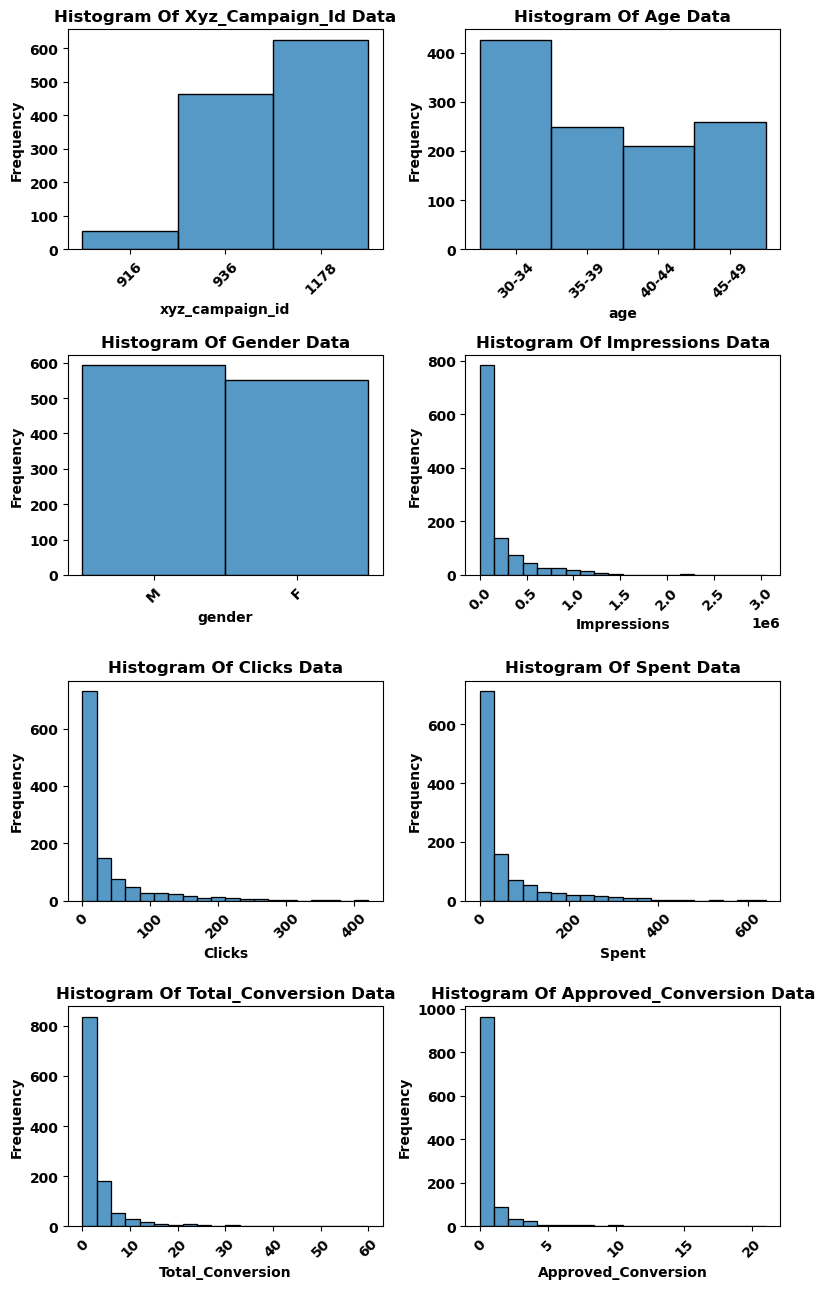

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

num_columns = df.shape[1]

# Calculate rows and columns for subplot grid
rows = int(np.ceil(num_columns / 2))
cols = 2

# Create a subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(8, 13))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Iterate through columns and create count plots
for idx, col in enumerate(df.columns):
    sns.histplot(df[col], bins=20, palette='pastel', ax=axes[idx])
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Histogram of {col} Data'.title())
    axes[idx].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for i in range(num_columns, rows * cols):
    axes[i].axis('off')

# Adjust layout and show plots
plt.tight_layout()
plt.show()

Some quick observations from these histograms are:

- The company focuses on ad campagins `1178` and `936` more than `916` given by the frequency of appearances.
- The most focused age group is 30-34 year olds where they are represented approximately 1.5 times more than other groups.
- The male to female audience ratio is roughly equal.
- The distributions for `Impressions`, `Clicks`, `Spent`, `Total_Conversion` and `Approved-Conversion` are relatively similar possibly because they are all highly correlated where more advertising money spent will lead to a greater number of impressions, clicks and consequently higher conversions.

Let's investigate the correlations of our features.

<AxesSubplot:>

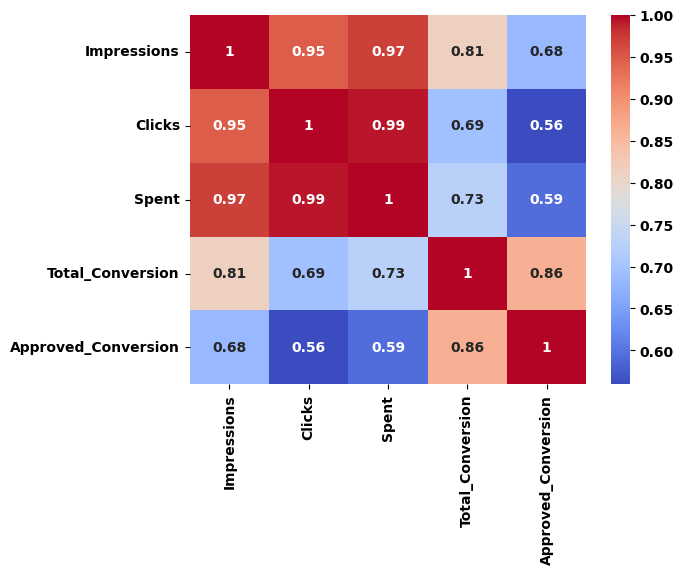

In [7]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)

As expected, the money `Spent` on an ad campagin is highly correlated to the number of `Impressions` and `Clicks` with a value of 0.97 and 0.99 respectively which is nearly a perfect linear dependence. Interestingly, the `Total_Conversion` rate is more strongly correlated to the number of `Impressions` than to the number of `Clicks` with a value of 0.81 and 0.69. The `Approved_Conversion` rate follows a similar trend where the coefficient for `Impressions` is 0.68 and `Clicks` is 0.56.

Let's move on to comparing the different ad campaigns to each other.

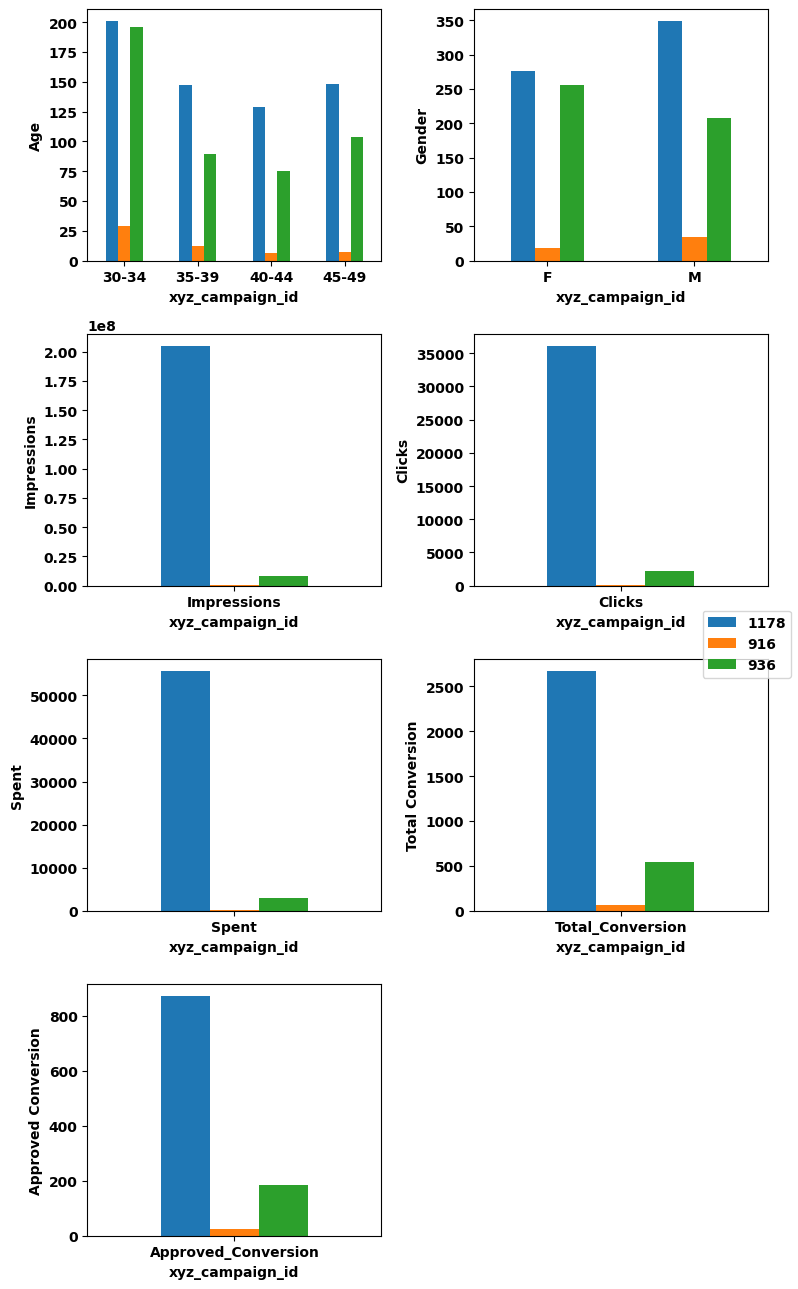

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(8,13))
axes = axes.flatten()
    
for i, column in enumerate(df.columns[1:]):
    ax = axes[i]
    if column in ['age', 'gender']:
        pivot_table = df[[column, 'xyz_campaign_id']].pivot_table(index=column, columns="xyz_campaign_id", aggfunc=len)
    else:
        pivot_table = df[[column, 'xyz_campaign_id']].pivot_table(columns="xyz_campaign_id", values=column, aggfunc=sum)
    pivot_table.plot(kind="bar", ax=ax, legend=None)
    ax.tick_params(labelrotation=0)
    ax.set_xlabel('xyz_campaign_id')
    ax.set_ylabel(column.replace("_", " ").title())
    
plt.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')
axes[7].axis('off')
plt.show()